In [107]:
%pip install rasterio rioxarray pykrige scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


In [108]:
import xarray as xr
import rioxarray as rxr
import pandas as pd

## Load DEM data

In [109]:
# Load high-resolution DEM with xarray.open_rasterio
dem = rxr.open_rasterio('sk_dem_small.tif')

dem = dem.sel(band=1)
dem = dem.where(dem != 0)
# Put variable name for dem
dem.name = "elev"

## Load Station Data

In [110]:

measurements = pd.read_csv("measurements.csv", sep=';')

## Prepare Data For Kriging

In [111]:
X = measurements[["lon", "lat"]].values
p = measurements[["lon", "lat", "elev"]].values
y = measurements[["ta_2m"]].values.ravel()

In [112]:
from sklearn.linear_model import LinearRegression
from pykrige.rk import RegressionKriging

## Perform Kriging

In [113]:
# Define regression model
reg_model = LinearRegression(n_jobs=-1)

# Initialize Regression Kriging with the chosen model
rk = RegressionKriging(
    method="universal",
    regression_model=reg_model,
    variogram_model="hole-effect",
    n_closest_points=10,
)

rk.fit(p=p, x=X, y=y)

## Reshape Data and Predict Grid

In [118]:
import numpy as np

# Create grid of longitudes and latitudes
lonsi, latsi = np.meshgrid(dem.x, dem.y)

# Flatten the arrays
x_pred = np.array(list(zip(lonsi.ravel(), latsi.ravel())))

# Align dimension names with our station data
dem_renamed = dem.rename({"x": "lon", "y": "lat"})

# Convert the DataArray to Pandas DataFrame
p_pred = dem_renamed.to_dataframe().reset_index()[["lon", "lat", "elev"]]

In [119]:
# Predict and reshape predicted values
# Also handle nans in our DEM
predicted_values = rk.predict(x=x_pred, p=np.where(np.isnan(p_pred), 0, p_pred))
predicted_values = np.where(np.isnan(p_pred["elev"]), np.nan, predicted_values).reshape(lonsi.shape)

n_closest_points will be ignored for UniversalKriging


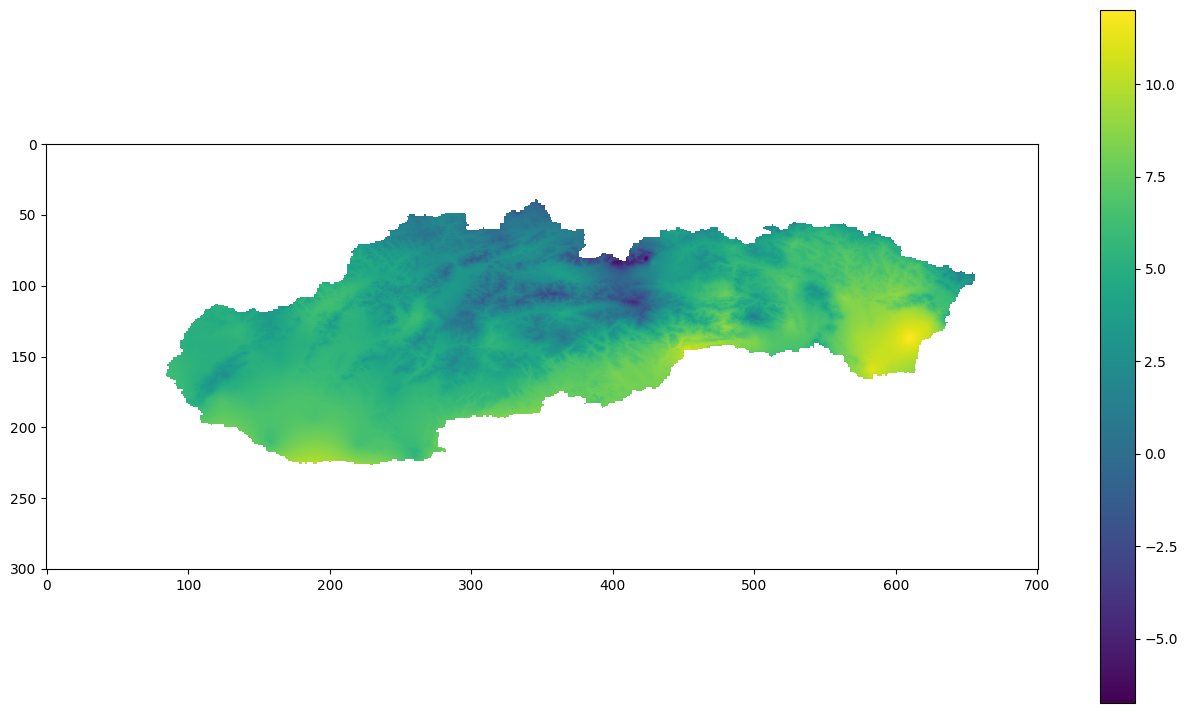

In [120]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(16,9))
plt.imshow(predicted_values)
plt.colorbar()
plt.show()

## Export Predicted values to .tif so we can visualize it in QGIS

In [121]:
predicted_da = xr.DataArray(
    predicted_values,
    coords=[("latitude", latsi[:, 0]), ("longitude", lonsi[0, :])],
)
predicted_da.rio.write_crs("epsg:4326", inplace=True)
predicted_da.rio.to_raster("interpolated_temperature.tif")
measurements[["City", "ta_2m", "lon", "lat", "elev"]].astype(
    {"ta_2m": float, "lat": float, "lon": float}
).to_csv("measurements.csv", sep=";", index=False)